# Beta-binomial model

In this notebook, we show the result of the analytical solution of the beta-binomial model.

In [37]:
from scipy.stats import beta
import numpy as np
import seaborn as sns; sns.set_context('notebook');
import matplotlib.pyplot as plt
%matplotlib inline

## More detailed problem description

### Bayesian clinical trial model
We have a treatment (let's neglect control group here) and we want to estimate the proportion of successful outcomes $p \in [0,1]$.

We formulate a clinical trial with the following assumptions: each treatment is independent and identically distributed (would you challenge these assumptions?) according to the Bernoulli distribution with probability of success $p$.  Then the number of $x$ successful treatments in $n$ treatment attempts is Binomially distributed.

We start with a prior distribution indicating equal belief in various values of $p$.

### Detecting a biased coin
We have a coin and our question is whether the coin is biased, that is, the probability of heads $p\neq\frac{1}{2}$.

We assume each coin flip is independent and identically distributed as a Bernoulli random variable. Thus $x$, the number of heads in $n$ coin flips is Binomially distributed.

## Mathematical setup

This is common for both scenarios.  Modelling assumption: $p$ is Beta distributed.  Our preferences then require that the prior is $p \sim \mathrm{Beta}(1,1)$, so

$$f(p,\alpha,\beta) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)} p^{\alpha-1} (1-p)^{\beta-1}.$$

Note: $\Gamma(x) = \int_{0}^\infty t^{x-1} \exp(-t) \mathrm{dt}$ is called the [gamma function](https://en.wikipedia.org/wiki/Gamma_function) (we don't need the integral anywhere, I just think it's cool) and for natural numbers $n$ we have $\Gamma(n) = (n-1)!$.

The likelihood is binomial, so given a probability of success $p$, we have

$$f(x|p,n) = \binom{n}{x} p^x(1-p)^{n-x}.$$

We want to solve for the posterior $f(p|x,n)$, which is proportional to

$$f(p|x,n) \propto f(p,\alpha,\beta)f(x|p,n).$$

We also know (via analytical derivation done on the board) that the analytical solution of the posterior is:

$$f(p|x,n) = \mathrm{Beta}(\alpha+x,\beta+n-x).$$

In [17]:
def prior_pdf(p):
    return beta.pdf(p,1,1)

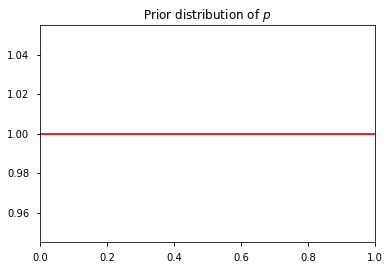

In [45]:
# I'm using z in place of p so I don't conflict later
# what you see is the density of p
z = np.linspace(0,1,100)
plt.plot(z, prior_pdf(z), color="r")
plt.xlim([0,1])
plt.title('Prior distribution of $p$')
plt.show()

In [21]:
def posterior_pdf(p,x,n):
    # given our prior was Beta(1,1), our posterior will be
    # Beta(1+x,1+n-x)
    return beta.pdf(p, x+1, n-x+1)

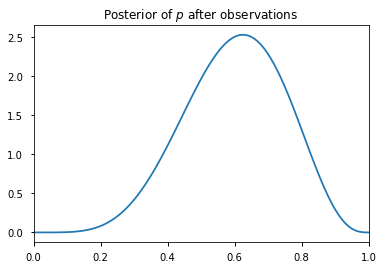

In [49]:
# experimental data
data = [1,1,0,1,0,1,1,0]
n, x = len(data), sum(data)

p = np.linspace(0,1,100)
plt.plot(p, posterior_pdf(p, x, n))
plt.xlim([0,1])
plt.title('Posterior of $p$ after observations')
plt.show()

### Coin flip experiment
Supposing we want to know whether a credible interval contains $p=0.5$.  A credible interval is the "Bayesian equivalent" of a confidence interval.

I will build the 95% credible interval by considering the interval between the 0.025 and 0.975 quantiles.

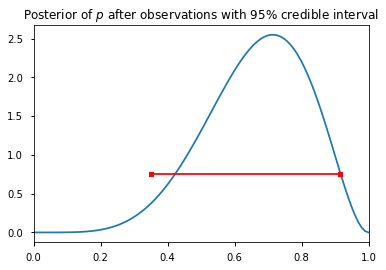

In [102]:
p = np.linspace(0,1,100)
plt.plot(p, posterior_pdf(p, x, n))
plt.plot([beta.ppf(0.025,x+1,n-x+1), beta.ppf(0.975,x+1,n-x+1)],
         [0.75, 0.75], color='r', marker='s', markersize=5)
plt.xlim([0,1])
plt.title('Posterior of $p$ after observations with 95% credible interval')
plt.show()

### "Monitoring" the progress
Since the distributions are conjugate, we can proceed inductively along experiments of size $n=1$ and plot the posterior (which we know is Beta distributed), which then becomes the new prior for the next result. So we can examine the distribution after each single trial.

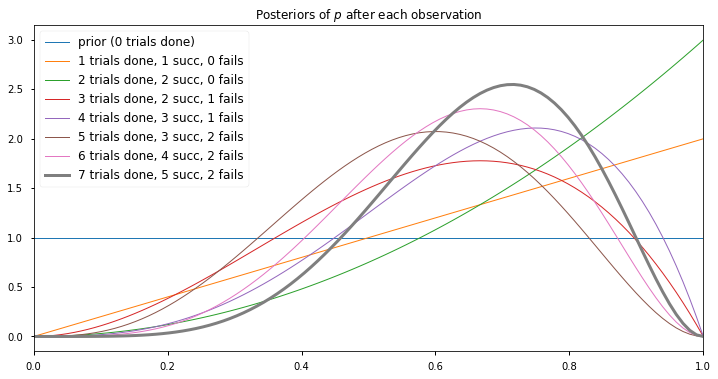

In [103]:
plt.figure(figsize=(12,6))
p = np.linspace(0,1,100)
legend = []
for n in range(0,len(data)):
    # update experiment after i-th trial
    succs = np.sum(data[:n]) 
    plt.plot(p, posterior_pdf(p, succs, n), linewidth=3 if n==len(data)-1 else 1)
    legend.append('%d trials done, %d succ, %d fails' % (n,succs,n-succs) if n > 0 else 'prior (0 trials done)')
plt.xlim([0,1])
plt.title('Posteriors of $p$ after each observation')
plt.legend(legend, fontsize=12)
plt.show()

## Solution using PyMC3
Let's build the same model and numerically integrate with PyMC3.

In [38]:
import pymc3 as pm

In [41]:
with pm.Model() as bb_model:
    p = pm.Beta('p', alpha=1, beta = 1)
    trials = pm.Binomial('trials', p=p, n=len(data), observed=sum(data))

### MAP estimate
The maximum aposteriori probability (MAP) estimate should plant itself right into the point with the highest probability density, that is (for a general $\theta$:

$$\theta_{\mathrm{MAP}} = \mathrm{argmax}_\theta\frac{f(D|\theta)f(\theta)}{f(D)}.$$

In [42]:
map_estimate = pm.find_MAP(model=bb_model)

logp = -1.5198, ||grad|| = 1: 100%|██████████| 7/7 [00:00<00:00, 568.93it/s]


In [43]:
map_estimate

{'p': array(0.625), 'p_logodds__': array(0.51082563)}

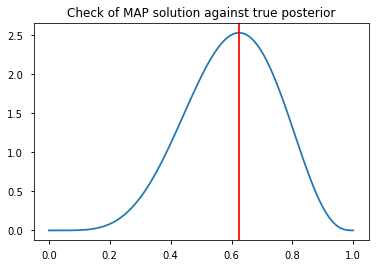

In [52]:
### Compare the MAP estimate to the known analytical posterior
plt.plot(z, posterior_pdf(z, sum(data), len(data)))
plt.axvline(map_estimate['p'], color='red')
plt.title('Check of MAP solution against true posterior')
plt.show()

### MCMC solution
We will not sample the posterior, plot the histogram and compare to the true posterior as before.

In [68]:
with bb_model:
    # draw posterior samples
    trace = pm.sample(draws=5000, discard_tuned_samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 5500/5500 [00:02<00:00, 2017.86it/s]


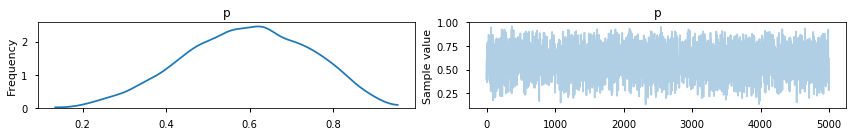

In [70]:
pm.traceplot(trace);

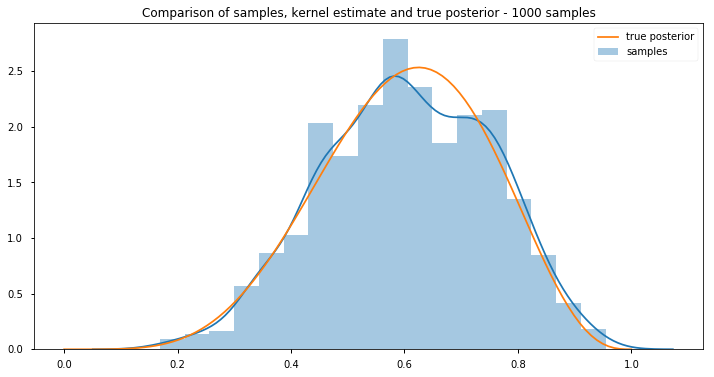

In [79]:
plt.figure(figsize=(12,6))
sns.distplot(trace['p'][:1000])
plt.plot(z, posterior_pdf(z, sum(data), len(data)))
plt.legend(['true posterior', 'samples'])
plt.title('Comparison of samples, kernel estimate and true posterior - 1000 samples')
plt.show()

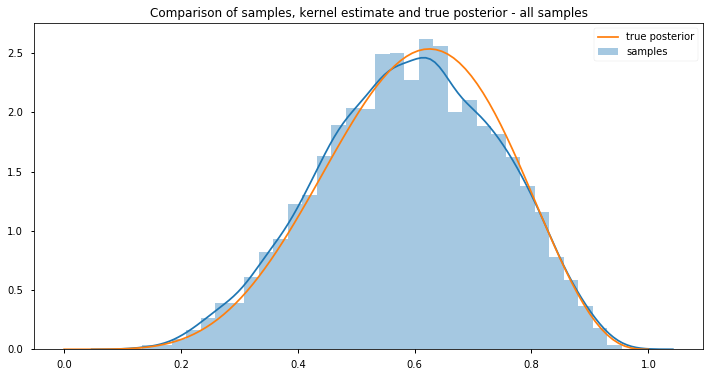

In [80]:
plt.figure(figsize=(12,6))
sns.distplot(trace['p'])
plt.plot(z, posterior_pdf(z, sum(data), len(data)))
plt.legend(['true posterior', 'samples'])
plt.title('Comparison of samples, kernel estimate and true posterior - all samples')
plt.show()

In [84]:
# the expected value from the samples
np.mean(trace['p'])

0.5911824435312734

In [86]:
# MLE estimate (should be under ideal conditions equal to MAP under uniform prior)
float(sum(data))/len(data)

0.625

In [ ]:
# Conclusion